In [127]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import progressbar
import catboost
from catboost import CatBoostClassifier
from catboost import Pool
from sklearn.preprocessing import LabelEncoder
from catboost import MetricVisualizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, f1_score
from sklearn.model_selection import train_test_split

import shap
shap.initjs()
import timeit

from sklearn.model_selection import train_test_split, GroupShuffleSplit, GridSearchCV, GroupKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, f1_score
from xgboost.sklearn import XGBRegressor, XGBClassifier
from imblearn.over_sampling import SMOTE

from catboost.utils import select_threshold
from catboost.utils import get_roc_curve
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

### Cross Validation Strategy

There are many possible options for cross validation / train_test_split strategy that must be addressed.

What train data can we use to make a fair prediction without introduction of any data leakage?
* This dataset has a time elemnent and features based on previous known customer behvaiour have been built into additional features. 
* We must therefore ensure that the test set being predicted does not contain any past data for a given customer.

We will use two options and build two different predictive models based on these assumption.
1. Predicting behaviour of new cutomers.
 1. Train and test sets will be split into groups with different customer ids. 
2. Predicting behaviour of existing customers.
 1. Test set will compomprise of the last offers given to a person, but previous behaviour will have been trained on

In [111]:
df = pd.read_pickle('../../data/interim/final_last_view.pickle')

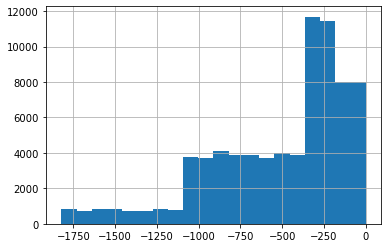

In [112]:
df.signed_up.hist(bins=20)

In [113]:
def label_encode_categories(df):
    '''
    label encodes gender and id, removing previous created one hot encoding    
    
    '''
    le = LabelEncoder()
    df.id = le.fit_transform(df.id)
    df.person = le.fit_transform(df.person)
    le.fit_transform(df.id)
    df['gender'] = df[['F', 'M', 'O']].idxmax(1)
    df.gender = le.fit_transform(df.gender)
    df = df.drop(['F', 'M', 'O'], axis=1)
    return df
df = label_encode_categories(df)
df.drop(['received_spend', 'viewed_spend', 'viewed_days_left', 'remaining to complete', 'viewed_in_valid', 'offer_spend'], axis=1, inplace=True)

In [114]:
def train_test_by_time(df, split):
    '''
    Splits dataframe into 75% train and 25% test by signed_up date.
    Test data is taken from the 25% newest offers, this comprises a different customer base to the train set and requries prediction of the future.    
    '''
        
    test_data = df[df.signed_up >= df.signed_up.quantile(q=split)]
    train_data = df[df.signed_up < df.signed_up.quantile(q=split)]
    
    y_train = train_data.complete
    X_train = train_data.drop('complete', axis=1)

    y_test = test_data.complete
    X_test = test_data.drop('complete', axis=1)
    
    
    print('X_train', X_train.shape, round(X_train.shape[0] / (X_train.shape[0]+X_test.shape[0]), 4))
    print('X_test', X_test.shape, round(X_test.shape[0] / (X_train.shape[0]+X_test.shape[0]), 4))
    print('y_train', y_train.shape)
    print('y_test', y_test.shape)
    
    return X_train, X_test, y_train, y_test

In [115]:
def shuffled_datasets(X, y):
    '''
    This checks whether folds are independent, positives per fold (stratification )
    '''

    train_fold=[]
    test_fold=[]
    total=[]
    intersect=[]
    positive_ratio=[]
    train_X=[]
    test_X=[]
    train_y, test_y = [], []
    test_lists = []
    test_overlap = []
    
    #for i,j in enumerate(GroupShuffleSplit(test_size=.2, n_splits=5, random_state=0).split(X, y, groups=X.person)):
    

    for i,j in enumerate(GroupKFold(n_splits=5).split(X, y, groups=X.person)):
        
        train_X.append(X.iloc[j[0]])
        train_y.append(y.iloc[j[0]])
        
        test_X.append(X.iloc[j[1]])
        test_y.append(y.iloc[j[1]])
        
        train_fold.append(X.iloc[j[0]].person)
        test_fold.append(X.iloc[j[1]].person)
        
        total.append(X.iloc[j[0]].person.nunique() + X.iloc[j[1]].person.nunique())
        
        intersect.append(np.intersect1d(X.iloc[j[0]].person, X.iloc[j[1]].person))
        
        positive_ratio.append(round(y_train.iloc[j[1]].sum() / y_train.iloc[j[1]].count(),3))
        
        test_lists.append(X.iloc[j[1]].person)
    
    for i in range(1,5):
        test_overlap.append(np.intersect1d(test_lists[0], test_lists[i]))
                            
    print('Total unique persons across train and test: ', total)
    print('Intersection of persons across train and test: ', intersect)
    print('Percentage of positive class per split: ', positive_ratio)
    print('Test overlap with first fold: ', test_overlap)
        
    return train_X, test_X, train_y, test_y

In [131]:
def fpr_fnr_curve(model, test_pool):
    '''
    Plots the trade off between 
    '''

    curve = get_roc_curve(model2, test_pool)
    (fpr, tpr, thresholds) = curve

    (thresholds, fpr) = get_fpr_curve(curve=curve)
    (thresholds, fnr) = get_fnr_curve(curve=curve)

    plt.figure(figsize=(16, 8))
    style = {'alpha':0.5, 'lw':2}

    plt.plot(thresholds, fpr, color='blue', label='FPR', **style)
    plt.plot(thresholds, fnr, color='green', label='FNR', **style)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    plt.xlabel('Threshold', fontsize=16)
    plt.ylabel('Error Rate', fontsize=16)
    plt.title('FPR-FNR curves', fontsize=20)
    plt.legend(loc="lower left", fontsize=16);

    print(select_threshold(model, test_pool, FNR=0.38))
    print(select_threshold(model, test_pool, FPR=0.38))
    return (select_threshold(model, test_pool, FNR=0.38))

In [116]:
X_train, X_test, y_train, y_test = train_test_by_time(df, .75)

X_train (57122, 54) 0.7489
X_test (19155, 54) 0.2511
y_train (57122,)
y_test (19155,)


In [117]:
train_X, test_X, train_y, test_y = shuffled_datasets(X_train, y_train)

Total unique persons across train and test:  [12742, 12742, 12742, 12742, 12742]
Intersection of persons across train and test:  [array([], dtype=int32), array([], dtype=int32), array([], dtype=int32), array([], dtype=int32), array([], dtype=int32)]
Percentage of positive class per split:  [0.069, 0.069, 0.072, 0.074, 0.07]
Test overlap with first fold:  [array([], dtype=int32), array([], dtype=int32), array([], dtype=int32), array([], dtype=int32)]


In [118]:
train_pool = Pool(data=train_X[0], label=train_y[0], cat_features=[0, 4, 53])
test_pool = Pool(data=test_X[0], label=test_y[0], cat_features = [0, 4, 53])

In [133]:
model2 = CatBoostClassifier(
    iterations=3000,
    learning_rate=0.01,
    max_depth=5,
    early_stopping_rounds=50,
    scale_pos_weight=y_train.count() / y_train.sum(),
    task_type='GPU',
    cat_features = [0, 4, 53],
    #boosting_type = 'Plain',
    #gpu_cat_features_storage = 'CpuPinnedMemory',
    verbose=20
)
model2.fit(
    train_pool,
    eval_set=test_pool,
    verbose=False,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.5640451822891767
0.5550410670986954


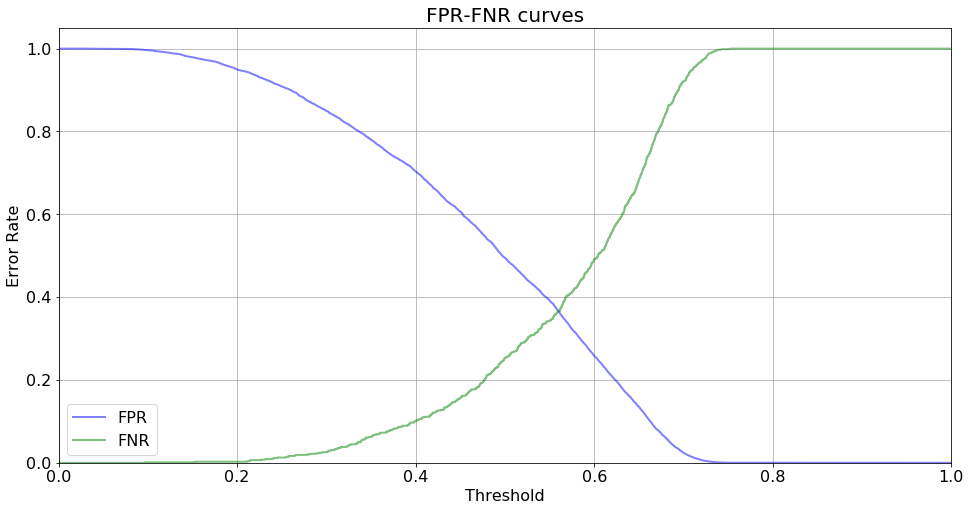

In [132]:
fnr = fpr_fnr_curve(model2, test_pool)

In [139]:
pred = model2.predict(test_X[0])
pred1 = model2.predict_proba(test_X[0])
confusion_matrix(test_y[0], pred)

array([[5194, 5447],
       [ 175,  609]], dtype=int64)

In [237]:
def fold_comparison(model):
    print('               TNR  TPR')
    for i in range(0,5):
        pred = model.predict(test_X[i])
        c = confusion_matrix(test_y[i], pred)
        
        TNR = round(c[0,0] / (c[0,0] + c[0,1]),2)
        TPR = round(c[1,1] / (c[1,0] + c[1,1]),2)
            
        print(i)
        print(c, TNR, TPR)
    
    pred = model.predict(X_test)
    c = confusion_matrix(y_test, pred)
    TNR = round(c[0,0] / (c[0,0] + c[0,1]),2)
    TPR = round(c[1,1] / (c[1,0] + c[1,1]),2)
    print('Test')
    print(c, TNR, TPR)

In [238]:
fold_comparison(model2)

               TNR  TPR
0
[[6025 4616]
 [ 111  673]] 0.57 0.86
1
[[4317 6315]
 [ 112  681]] 0.41 0.86
2
[[5941 4658]
 [ 126  699]] 0.56 0.85
3
[[6134 4448]
 [ 106  736]] 0.58 0.87
4
[[6230 4396]
 [ 114  684]] 0.59 0.86
Test
[[11650  6894]
 [  221   390]] 0.63 0.64


### Training fold 1

In [199]:
train_pool = Pool(data=train_X[1], label=train_y[1], cat_features=[0, 4, 53])
test_pool = Pool(data=test_X[1], label=test_y[1], cat_features = [0, 4, 53])

In [203]:
model3 = CatBoostClassifier(
    iterations=3000,
    learning_rate=0.01,
    max_depth=5,
    early_stopping_rounds=50,
    scale_pos_weight=y_train.count() / y_train.sum(),
    task_type='GPU',
    cat_features = [0, 4, 53],
    #boosting_type = 'Plain',
    #gpu_cat_features_storage = 'CpuPinnedMemory',
    verbose=20
)
model3.fit(
    train_pool,
    eval_set=test_pool,
    verbose=False,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [239]:
fold_comparison(model3)

               TNR  TPR
0
[[6025 4616]
 [ 111  673]] 0.57 0.86
1
[[4317 6315]
 [ 112  681]] 0.41 0.86
2
[[5941 4658]
 [ 126  699]] 0.56 0.85
3
[[6134 4448]
 [ 106  736]] 0.58 0.87
4
[[6230 4396]
 [ 114  684]] 0.59 0.86
Test
[[11650  6894]
 [  221   390]] 0.63 0.64


In [241]:
train_pool = Pool(data=train_X[2], label=train_y[2], cat_features=[0, 4, 53])
test_pool = Pool(data=test_X[2], label=test_y[2], cat_features = [0, 4, 53])

model4 = CatBoostClassifier(
    iterations=3000,
    learning_rate=0.01,
    max_depth=5,
    early_stopping_rounds=50,
    scale_pos_weight=y_train.count() / y_train.sum(),
    task_type='GPU',
    cat_features = [0, 4, 53],
    #boosting_type = 'Plain',
    #gpu_cat_features_storage = 'CpuPinnedMemory',
    verbose=20
)
model4.fit(
    train_pool,
    eval_set=test_pool,
    verbose=False,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [242]:
fold_comparison(model4)

               TNR  TPR
0
[[6126 4515]
 [ 130  654]] 0.58 0.83
1
[[6220 4412]
 [ 122  671]] 0.59 0.85
2
[[3857 6742]
 [ 129  696]] 0.36 0.84
3
[[6275 4307]
 [ 132  710]] 0.59 0.84
4
[[6366 4260]
 [ 130  668]] 0.6 0.84
Test
[[9069 9475]
 [ 167  444]] 0.49 0.73


The above separates customers.... and test also separates by newest customer.

### why is it that the test set performs much more poorly than the validation set?

Try splitting the whole thing into 5 folds - this time we can see if better accuracy can be gained 

In [251]:
train_pool = Pool(data=train_X[2], label=train_y[2], cat_features=[0, 4, 53])
test_pool = Pool(data=test_X[2], label=test_y[2], cat_features = [0, 4, 53])

model4 = CatBoostClassifier(
    iterations=3000,
    learning_rate=0.01,
    max_depth=5,
    early_stopping_rounds=50,
    scale_pos_weight=y_train.count() / y_train.sum(),
    task_type='GPU',
    cat_features = [0, 4, 53],
    custom_loss=['AUC', 'Accuracy', 'F1', 'Recall', 'Precision'],
    #boosting_type = 'Plain',
    #gpu_cat_features_storage = 'CpuPinnedMemory',
    verbose=20
)
model4.fit(
    train_pool,
    eval_set=test_pool,
    verbose=False,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [260]:
train_pool = Pool(data=train_X[2], label=train_y[2], cat_features=[0, 4, 53])
test_pool = Pool(data=test_X[2], label=test_y[2], cat_features = [0, 4, 53])

model5 = CatBoostClassifier(
    iterations=3000,
    learning_rate=0.01,
    max_depth=5,
    early_stopping_rounds=200,
    scale_pos_weight=y_train.count() / y_train.sum(),
    task_type='GPU',
    cat_features = [0, 4, 53],
    eval_metric='AUC',
    
    #custom_loss=['AUC', 'Accuracy', 'F1', 'Recall', 'Precision'],
    #boosting_type = 'Plain',
    #gpu_cat_features_storage = 'CpuPinnedMemory',
    verbose=20
)
model5.fit(
    train_pool,
    eval_set=test_pool,
    verbose=False,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [261]:
fold_comparison(model5)

               TNR  TPR
0
[[6163 4478]
 [ 136  648]] 0.58 0.83
1
[[6250 4382]
 [ 124  669]] 0.59 0.84
2
[[4169 6430]
 [ 145  680]] 0.39 0.82
3
[[6300 4282]
 [ 135  707]] 0.6 0.84
4
[[6389 4237]
 [ 142  656]] 0.6 0.82
Test
[[9962 8582]
 [ 188  423]] 0.54 0.69


In [258]:
fold_comparison(model4)

               TNR  TPR
0
[[6722 3919]
 [  96  688]] 0.63 0.88
1
[[6800 3832]
 [  85  708]] 0.64 0.89
2
[[5781 4818]
 [ 236  589]] 0.55 0.71
3
[[6815 3767]
 [  92  750]] 0.64 0.89
4
[[6890 3736]
 [  91  707]] 0.65 0.89
Test
[[14602  3942]
 [  351   260]] 0.79 0.43


In [257]:
train_pool = Pool(data=train_X[2], label=train_y[2], cat_features=[0, 4, 53])
test_pool = Pool(data=test_X[2], label=test_y[2], cat_features = [0, 4, 53])

model4 = CatBoostClassifier(
    iterations=3000,
    learning_rate=0.01,
    max_depth=5,
    early_stopping_rounds=200,
    scale_pos_weight=y_train.count() / y_train.sum(),
    task_type='GPU',
    cat_features = [0, 4, 53],
    custom_loss=['AUC', 'Accuracy', 'F1', 'Recall', 'Precision'],
    #boosting_type = 'Plain',
    #gpu_cat_features_storage = 'CpuPinnedMemory',
    verbose=20
)
model4.fit(
    train_pool,
    eval_set=test_pool,
    verbose=False,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Separate and make split with last known offer given - check what the percentage split is?

In [314]:
def last_offer_split(df):
    '''
    Splits dataframe into 75% train and 25% test by signed_up date.
    Test data is taken from the 25% newest offers, this comprises a different customer base to the train set and requries prediction of the future.    
    '''
    
    # get indices with latest offer time for each person.
    idx = df.groupby(['person'])['time'].transform(max) == df['time']
        
    test_data = df[idx]
    train_data = df[~idx]
    
    y_train = train_data.complete
    X_train = train_data.drop('complete', axis=1)

    y_test = test_data.complete
    X_test = test_data.drop('complete', axis=1)
    
    
    print('X_train', X_train.shape, round(X_train.shape[0] / (X_train.shape[0]+X_test.shape[0]), 4))
    print('X_test', X_test.shape, round(X_test.shape[0] / (X_train.shape[0]+X_test.shape[0]), 4))
    print('y_train', y_train.shape)
    print('y_test', y_test.shape)
    
    return X_train, X_test, y_train, y_test

In [315]:
X_train, X_test, y_train, y_test = last_offer_split(df)

X_train (59283, 54) 0.7772
X_test (16994, 54) 0.2228
y_train (59283,)
y_test (16994,)


In [361]:
train_pool = Pool(data=X_train, label=y_train, cat_features=[0, 4, 53])
test_pool = Pool(data=X_test, label=y_test, cat_features = [0, 4, 53])

CatBoostError: Invalid cat_features[2] = 53 value: must be < 34.

In [318]:
model5 = CatBoostClassifier(
    iterations=3000,
    learning_rate=0.01,
    max_depth=5,
    early_stopping_rounds=200,
    scale_pos_weight=y_train.count() / y_train.sum(),
    task_type='GPU',
    cat_features = [0, 4, 53],
    custom_loss=['AUC', 'Accuracy', 'F1', 'Recall', 'Precision'],
    #boosting_type = 'Plain',
    #gpu_cat_features_storage = 'CpuPinnedMemory',
    verbose=20
)
model5.fit(
    train_pool,
    eval_set=test_pool,
    verbose=False,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [319]:
fold_comparison(model5)

               TNR  TPR
0
[[5543 5098]
 [  63  721]] 0.52 0.92
1
[[5617 5015]
 [  72  721]] 0.53 0.91
2
[[5497 5102]
 [  74  751]] 0.52 0.91
3
[[5665 4917]
 [  63  779]] 0.54 0.93
4
[[5742 4884]
 [  62  736]] 0.54 0.92
Test
[[8093 7678]
 [ 188 1035]] 0.51 0.85


In [332]:
pred = model5.predict(X_test)
pred1 = model5.predict_proba(X_test)
confusion_matrix(y_test, pred)

array([[8093, 7678],
       [ 188, 1035]], dtype=int64)

In [343]:
preddy = (pred1 > .55)[:,1]*1
confusion_matrix(y_test, preddy)

array([[9059, 6712],
       [ 264,  959]], dtype=int64)

0.636240537173102
0.5857157596336278


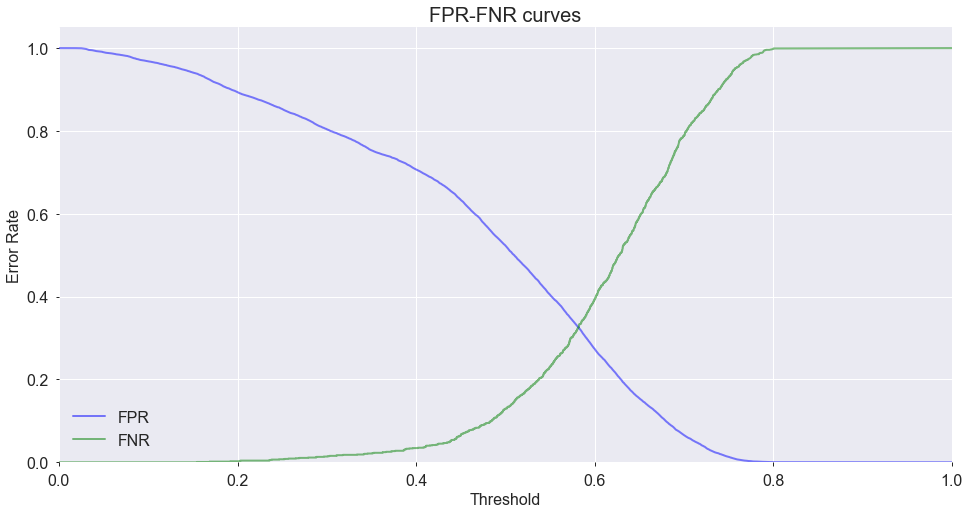

In [335]:
fnr = fpr_fnr_curve(model5, test_pool)

In [320]:
model6 = CatBoostClassifier(
    iterations=3000,
    learning_rate=0.01,
    max_depth=8,
    early_stopping_rounds=200,
    scale_pos_weight=y_train.count() / y_train.sum(),
    task_type='GPU',
    cat_features = [0, 4, 53],
    custom_loss=['AUC', 'Accuracy', 'F1', 'Recall', 'Precision'],
    #boosting_type = 'Plain',
    #gpu_cat_features_storage = 'CpuPinnedMemory',
    verbose=20
)
model6.fit(
    train_pool,
    eval_set=test_pool,
    verbose=False,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [321]:
fold_comparison(model6)

               TNR  TPR
0
[[6019 4622]
 [  54  730]] 0.57 0.93
1
[[6100 4532]
 [  57  736]] 0.57 0.93
2
[[5961 4638]
 [  70  755]] 0.56 0.92
3
[[6108 4474]
 [  54  788]] 0.58 0.94
4
[[6183 4443]
 [  61  737]] 0.58 0.92
Test
[[8709 7062]
 [ 232  991]] 0.55 0.81


In [322]:
model7 = CatBoostClassifier(
    iterations=3000,
    learning_rate=0.005,
    max_depth=6,
    early_stopping_rounds=200,
    scale_pos_weight=y_train.count() / y_train.sum(),
    task_type='GPU',
    cat_features = [0, 4, 53],
    custom_loss=['AUC', 'Accuracy', 'F1', 'Recall', 'Precision'],
    #boosting_type = 'Plain',
    #gpu_cat_features_storage = 'CpuPinnedMemory',
    verbose=20
)
model7.fit(
    train_pool,
    eval_set=test_pool,
    verbose=False,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [323]:
fold_comparison(model7)

               TNR  TPR
0
[[5675 4966]
 [  65  719]] 0.53 0.92
1
[[5749 4883]
 [  63  730]] 0.54 0.92
2
[[5635 4964]
 [  75  750]] 0.53 0.91
3
[[5792 4790]
 [  60  782]] 0.55 0.93
4
[[5871 4755]
 [  60  738]] 0.55 0.92
Test
[[8316 7455]
 [ 203 1020]] 0.53 0.83


In [345]:
importance = np.array(model5.get_feature_importance(prettified=True))
importance

array([['person', 17.39155924387456],
       ['hist_failed_complete', 16.84654094954503],
       ['t_2000', 13.025283415375995],
       ['last_amount', 10.331753908661744],
       ['income', 5.345102909452044],
       ['t_365', 5.0029173857724425],
       ['signed_up', 3.8786535763339387],
       ['id', 3.8265159537174886],
       ['difficulty', 3.2937527633398087],
       ['age', 2.2827914817351886],
       ['last_transaction', 1.8172020470918544],
       ['duration', 1.79604710519701],
       ['reward', 1.6868450504181376],
       ['last_transaction_days', 1.479612929778509],
       ['mobile', 1.439195157325363],
       ['t_365c', 1.3156782359285248],
       ['hist_difficulty_possible', 0.9295715957035842],
       ['informational', 0.8419794774792692],
       ['time', 0.8172444822645352],
       ['last_view_date', 0.7655455209942102],
       ['completed_ratio', 0.753331762929896],
       ['date', 0.6920776788527765],
       ['hist_received_spend', 0.6555387848192378],
       ['ratio_

In [351]:
importance_remove = np.array(model5.get_feature_importance(train_pool,
    'LossFunctionChange',
    prettified=True
))
importance_remove

array([['t_365', 0.022316332250555238],
       ['person', 0.018784814021622243],
       ['last_amount', 0.013421390148897594],
       ['hist_failed_complete', 0.006868996716543951],
       ['income', 0.0055592701036600856],
       ['signed_up', 0.005554051877150301],
       ['last_transaction', 0.0048233322563286385],
       ['reward', 0.004604054763266807],
       ['id', 0.0034239919461548918],
       ['difficulty', 0.0033636465125385095],
       ['age', 0.0017703793180963157],
       ['t_2000', 0.0017584350759509704],
       ['duration', 0.0015040221463645809],
       ['mobile', 0.0011246560411579676],
       ['hist_previous_offers', 0.0010672708883802118],
       ['ratio_reward/offered', 0.0010568845325543696],
       ['t_365c', 0.0007313951805649754],
       ['last_view_date', 0.0007186194631314535],
       ['last_transaction_days', 0.0006744685095867453],
       ['ratio_difficulty/offered', 0.0006607724075995414],
       ['hist_reward_possible', 0.0006606897876371143],
       ['hi

In [347]:
importance_remove = np.array(model5.get_feature_importance(test_pool,
    'LossFunctionChange',
    prettified=True
))
importance_remove

array([['last_amount', 0.015094616562871144],
       ['income', 0.005802589391570828],
       ['signed_up', 0.004592865372915672],
       ['t_365', 0.004281983005437973],
       ['reward', 0.004158074564753145],
       ['last_transaction', 0.0032498674208393252],
       ['difficulty', 0.003003138342160594],
       ['id', 0.0029972589853081433],
       ['t_2000', 0.0018228232693190405],
       ['duration', 0.001413118157693738],
       ['age', 0.0012085965099252194],
       ['last_view_date', 0.0006910277168640233],
       ['informational', 0.000635598915534441],
       ['person', 0.0005326881521160454],
       ['t_2000c', 0.000350943853109964],
       ['t_365c', 0.00031253536219177924],
       ['hist_failed_complete', 0.0002760401517361011],
       ['mobile', 0.00021939973135765012],
       ['time', 0.00018674703142906868],
       ['date', 0.00012870353461769124],
       ['ratio_reward/offered', 0.00012098707112173646],
       ['hist_difficulty_possible', 0.00011967164935700048],
     

In [327]:
shap_values = model7.get_feature_importance(test_pool, 'ShapValues')
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

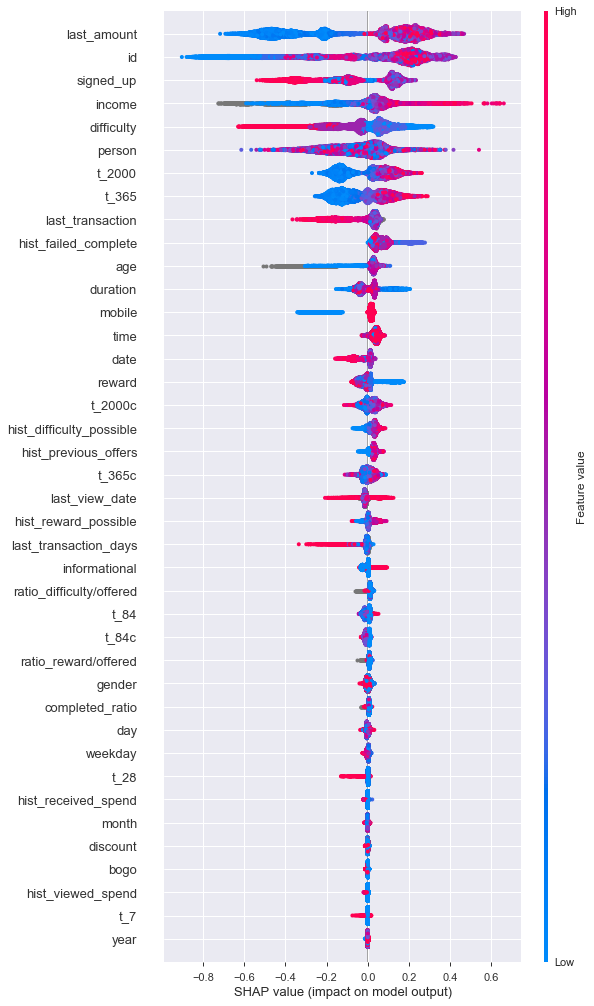

In [329]:
shap.summary_plot(shap_values, X_test, max_display=40)

In [330]:
df

person  time   age    income  id  rewarded  difficulty  reward  \
0        7994     0  75.0  100000.0   6       0.0         5.0     5.0   
1        7994   168  75.0  100000.0   9       0.0         0.0     0.0   
2        7994   408  75.0  100000.0   1       0.0        10.0    10.0   
3        7994   504  75.0  100000.0   7       0.0         5.0     5.0   
4       10733     0   NaN       NaN   0       0.0        20.0     5.0   
...       ...   ...   ...       ...  ..       ...         ...     ...   
76272   10710   504  47.0   94000.0   8       0.0         0.0     0.0   
76273   10710   576  47.0   94000.0   2       0.0        10.0    10.0   
76274   15672   576   NaN       NaN   3       0.0        10.0     2.0   
76275    9681   576   NaN       NaN   2       0.0        10.0    10.0   
76276    3162   576  58.0   78000.0   2       0.0        10.0    10.0   

       duration  mobile  web  social  bogo  discount  informational  \
0           7.0     1.0  1.0     0.0   1.0       0.0            0.0   
1           3.0     1.0  0.0     1.0   0.0       0.0            1.0   
2           7.0     1.0  0.0     1.0   1.0       0.0            0.0   
3           5.0     1.0  1.0     1.0   1.0       0.0            0.0   
4          10.0     0.0  1.0     0.0   0.0       1.0            0.0   
...         ...     ...  ...     ...   ...       ...            ...   
76272       4.0     1.0  1.0     0.0   0.0       0.0            1.0   
76273       5.0     1.0  1.0     1.0   1.0       0.0            0.0   
76274      10.0     1.0  1.0     1.0   0.0       1.0            0.0   
76275       5.0     1.0  1.0     1.0   1.0       0.0            0.0   
76276       5.0     1.0  1.0     1.0   1.0       0.0            0.0   

       signed_up  date  weekday  month  year  day  last_transaction  \
0           -443  -443        1      5  2017    9               NaN   
1           -443  -275        1     10  2017   24            -299.0   
2           -443   -35        3      6  2018   21             -65.0   
3           -443    61        1      9  2018   25             -65.0   
4           -356  -356        4      8  2017    4               NaN   
...          ...   ...      ...    ...   ...  ...               ...   
76272       -286   218        4      3  2019    1               NaN   
76273       -286   290        6      5  2019   12               NaN   
76274       -235   341        1      7  2019    2             281.0   
76275       -303   273        3      4  2019   25               NaN   
76276       -644   -68        5      5  2018   19               NaN   

       last_transaction_days  last_amount  t_7  t_14   t_28   t_84   t_365  \
0                        NaN         0.00  0.0   0.0   0.00   0.00    0.00   
1                       24.0        17.78  0.0   0.0  17.78  37.67   37.67   
2                       30.0        23.93  0.0   0.0   0.00  23.93  110.99   
3                      126.0        23.93  0.0   0.0   0.00   0.00   91.10   
4                        NaN         0.00  0.0   0.0   0.00   0.00    0.00   
...                      ...          ...  ...   ...    ...    ...     ...   
76272                    NaN         0.00  0.0   0.0   0.00   0.00    0.00   
76273                    NaN         0.00  0.0   0.0   0.00   0.00    0.00   
76274                   60.0         2.57  0.0   0.0   0.00   2.57    2.57   
76275                    NaN         0.00  0.0   0.0   0.00   0.00    0.00   
76276                    NaN         0.00  0.0   0.0   0.00   0.00    0.00   

       t_2000  t_7c  t_14c  t_28c  t_84c  t_365c  t_2000c  complete  \
0        0.00     0      0      0      0       0        0         0   
1       37.67     0      0      1      2       2        2         0   
2      110.99     0      0      0      1       5        5         0   
3      110.99     0      0      0      0       4        5         0   
4        0.00     0      0      0      0       0        0         0   
...       ...   ...    ...    ...    ...     ...      ...    

In [348]:
df = pd.read_pickle('../../data/interim/final_last_view.pickle')
df = label_encode_categories(df)
df.drop(['received_spend', 'viewed_spend', 'viewed_days_left', 'remaining to complete', 'viewed_in_valid', 'offer_spend'], axis=1, inplace=True)

In [358]:
df.drop(['weekday',
    'month',
    'ratio_viewed_complete',
    'hist_viewed_spend',
    't_14',
    'social',
    'discount',
    'hist_difficulty_completed',
    'year',
    't_7c',
    'rewarded',
    'web',
    'bogo',
    't_14c',
    't_28c',
    'hist_reward_completed',
    'hist_previous_completed',
    'hist_viewed_and_completed',
    'hist_complete_not_viewed',
    'hist_viewed'], axis=1, inplace=True)

In [359]:
X_train, X_test, y_train, y_test = last_offer_split(df)

X_train (59283, 34) 0.7772
X_test (16994, 34) 0.2228
y_train (59283,)
y_test (16994,)


In [372]:
df.iloc[:,34]

0        0
1        0
2        0
3        0
4        0
        ..
76272    1
76273    1
76274    0
76275    0
76276    0
Name: gender, Length: 76277, dtype: int32

In [374]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((59283, 34), (16994, 34), (59283,), (16994,))

In [375]:
X_train

person  time   age    income  id  difficulty  reward  duration  mobile  \
0        7994     0  75.0  100000.0   6         5.0     5.0       7.0     1.0   
1        7994   168  75.0  100000.0   9         0.0     0.0       3.0     1.0   
2        7994   408  75.0  100000.0   1        10.0    10.0       7.0     1.0   
4       10733     0   NaN       NaN   0        20.0     5.0      10.0     0.0   
5       10733   336   NaN       NaN   8         0.0     0.0       4.0     1.0   
...       ...   ...   ...       ...  ..         ...     ...       ...     ...   
76264   16772   504  60.0   94000.0   7         5.0     5.0       5.0     1.0   
76266    4762   504  24.0   56000.0   1        10.0    10.0       7.0     1.0   
76268    3716   504  58.0   57000.0   1        10.0    10.0       7.0     1.0   
76270    8872   504  48.0   58000.0   2        10.0    10.0       5.0     1.0   
76272   10710   504  47.0   94000.0   8         0.0     0.0       4.0     1.0   

       informational  signed_up  date  day  last_transaction  \
0                0.0       -443  -443    9               NaN   
1                1.0       -443  -275   24            -299.0   
2                0.0       -443   -35   21             -65.0   
4                0.0       -356  -356    4               NaN   
5                1.0       -356   -20    6             -92.0   
...              ...        ...   ...  ...               ...   
76264            0.0       -735  -231    7               NaN   
76266            0.0       -260   244   27               NaN   
76268            0.0       -324   180   22               NaN   
76270            0.0        -46   458   27               NaN   
76272            1.0       -286   218    1               NaN   

       last_transaction_days  last_amount  t_7   t_28   t_84   t_365  t_2000  \
0                        NaN         0.00  0.0   0.00   0.00    0.00    0.00   
1                       24.0        17.78  0.0  17.78  37.67   37.67   37.67   
2                       30.0        23.93  0.0   0.00  23.93  110.99  110.99   
4                        NaN         0.00  0.0   0.00   0.00    0.00    0.00   
5                       72.0         3.50  0.0   0.00   3.50    4.59    4.59   
...                      ...          ...  ...    ...    ...     ...     ...   
76264                    NaN         0.00  0.0   0.00   0.00    0.00    0.00   
76266                    NaN         0.00  0.0   0.00   0.00    0.00    0.00   
76268                    NaN         0.00  0.0   0.00   0.00    0.00    0.00   
76270                    NaN         0.00  0.0   0.00   0.00    0.00    0.00   
76272                    NaN         0.00  0.0   0.00   0.00    0.00    0.00   

       t_84c  t_365c  t_2000c  hist_reward_possible  hist_difficulty_possible  \
0          0       0        0                   0.0                       0.0   
1          2       2        2                   5.0                       5.0   
2          1       5        5                   5.0                       5.0   
4          0       0        0                   0.0                       0.0   
5          1       2        2                   5.0                      20.0   
...      ...     ...      ...                   ...                       ...   
76264      0       0        0                   0.0                       0.0   
76266      0       0        0                   0.0                       0.0   
76268      0       0        0                   0.0                       0.0   
76270      0       0        0                   0.0                       0.0   
76272      0       0        0                   0.0                       0.0   

       hist_previous_offers  hist_failed_complete  ratio_reward/offered  \
0                         0                     0                   NaN   
1                         1                     1                   0.0   
2                         2                     2                   0.0   
4                         0    

In [396]:
train_pool = Pool(data=X_train, label=y_train, cat_features=[0,4,33])
test_pool = Pool(data=X_test, label=y_test, cat_features=[0,4,33])

In [391]:
X_train

person  time   age    income  id  difficulty  reward  duration  mobile  \
0        7994     0  75.0  100000.0   6         5.0     5.0       7.0     1.0   
1        7994   168  75.0  100000.0   9         0.0     0.0       3.0     1.0   
2        7994   408  75.0  100000.0   1        10.0    10.0       7.0     1.0   
4       10733     0   NaN       NaN   0        20.0     5.0      10.0     0.0   
5       10733   336   NaN       NaN   8         0.0     0.0       4.0     1.0   
...       ...   ...   ...       ...  ..         ...     ...       ...     ...   
76264   16772   504  60.0   94000.0   7         5.0     5.0       5.0     1.0   
76266    4762   504  24.0   56000.0   1        10.0    10.0       7.0     1.0   
76268    3716   504  58.0   57000.0   1        10.0    10.0       7.0     1.0   
76270    8872   504  48.0   58000.0   2        10.0    10.0       5.0     1.0   
76272   10710   504  47.0   94000.0   8         0.0     0.0       4.0     1.0   

       informational  signed_up  date  day  last_transaction  \
0                0.0       -443  -443    9               NaN   
1                1.0       -443  -275   24            -299.0   
2                0.0       -443   -35   21             -65.0   
4                0.0       -356  -356    4               NaN   
5                1.0       -356   -20    6             -92.0   
...              ...        ...   ...  ...               ...   
76264            0.0       -735  -231    7               NaN   
76266            0.0       -260   244   27               NaN   
76268            0.0       -324   180   22               NaN   
76270            0.0        -46   458   27               NaN   
76272            1.0       -286   218    1               NaN   

       last_transaction_days  last_amount  t_7   t_28   t_84   t_365  t_2000  \
0                        NaN         0.00  0.0   0.00   0.00    0.00    0.00   
1                       24.0        17.78  0.0  17.78  37.67   37.67   37.67   
2                       30.0        23.93  0.0   0.00  23.93  110.99  110.99   
4                        NaN         0.00  0.0   0.00   0.00    0.00    0.00   
5                       72.0         3.50  0.0   0.00   3.50    4.59    4.59   
...                      ...          ...  ...    ...    ...     ...     ...   
76264                    NaN         0.00  0.0   0.00   0.00    0.00    0.00   
76266                    NaN         0.00  0.0   0.00   0.00    0.00    0.00   
76268                    NaN         0.00  0.0   0.00   0.00    0.00    0.00   
76270                    NaN         0.00  0.0   0.00   0.00    0.00    0.00   
76272                    NaN         0.00  0.0   0.00   0.00    0.00    0.00   

       t_84c  t_365c  t_2000c  hist_reward_possible  hist_difficulty_possible  \
0          0       0        0                   0.0                       0.0   
1          2       2        2                   5.0                       5.0   
2          1       5        5                   5.0                       5.0   
4          0       0        0                   0.0                       0.0   
5          1       2        2                   5.0                      20.0   
...      ...     ...      ...                   ...                       ...   
76264      0       0        0                   0.0                       0.0   
76266      0       0        0                   0.0                       0.0   
76268      0       0        0                   0.0                       0.0   
76270      0       0        0                   0.0                       0.0   
76272      0       0        0                   0.0                       0.0   

       hist_previous_offers  hist_failed_complete  ratio_reward/offered  \
0                         0                     0                   NaN   
1                         1                     1                   0.0   
2                         2                     2                   0.0   
4                         0    

In [402]:
model5 = CatBoostClassifier(
    iterations=3000,
    learning_rate=0.01,
    max_depth=5,
    early_stopping_rounds=200,
    scale_pos_weight=y_train.count() / y_train.sum(),
    task_type='GPU',
    custom_loss=['AUC', 'Accuracy', 'F1', 'Recall', 'Precision'],
    cat_features=[0,4,33],
    
    #boosting_type = 'Plain',
    #gpu_cat_features_storage = 'CpuPinnedMemory',
    verbose=20
)
model5.fit(
    train_pool,
    eval_set=test_pool,
    verbose=False,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [403]:
pred = model5.predict(X_test)
pred1 = model5.predict_proba(X_test)
confusion_matrix(y_test, pred)

array([[8026, 7745],
       [ 180, 1043]], dtype=int64)